## Importing the libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Loading the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
training_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CryptoPricePredictionApp/train.csv")

In [5]:
training_data

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [6]:
Bitcoin = training_data.loc[training_data['Asset_ID'] == 1].set_index("timestamp")

btc_mini = Bitcoin.iloc[-200:]

## Visualizing the data

In [7]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

## Pre-processing the data

In [8]:
def make_dataset(data, window):
  samples = []
  labels = []
  for i in range(window-1, len(data)):
    samples.append(data[i-(window-1):i])
    labels.append(data[i])
  return samples, labels

In [9]:
features, labels = make_dataset(list(Bitcoin['VWAP']), 101)

In [10]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(features)

In [11]:
def mini_batch(features, labels, batch_size):
  batched_features = []
  batched_labels = []
  dataset_size = int(len(features)/batch_size)*batch_size
  features = features[:dataset_size]
  labels = labels[:dataset_size]
  for i in range(0, dataset_size, batch_size):
    batched_features.append(features[i:i+batch_size])
    batched_labels.append(labels[i:i+batch_size])
  return batched_features, batched_labels

In [12]:
def test_train_split(batched_features, batched_labels, test_ratio):
  train_batch_size = int(len(batched_features)*(1-test_ratio))
  training_batch_features = batched_features[:train_batch_size]
  training_batch_labels = batched_labels[:train_batch_size]
  test_batch_features = batched_features[train_batch_size:]
  test_batch_labels = batched_labels[train_batch_size:]
  return training_batch_features, training_batch_labels, test_batch_features, test_batch_labels

In [13]:
batched_features, batched_labels = mini_batch(X_btc_train_scaled, labels, 64)

training_batch_features, training_batch_labels, test_batch_features, test_batch_labels = test_train_split(batched_features, batched_labels, 0.2)

In [14]:
training_batch_features = np.array(training_batch_features)
training_batch_labels = np.array(training_batch_labels)

test_batch_features = np.array(test_batch_features)
test_batch_labels = np.array(test_batch_labels)

In [15]:
test_batch_labels.shape

(6113, 64)

## Model Architecture

In [16]:
# tf.debugging.set_log_device_placement(True)


model = tf.keras.Sequential([
                             tf.keras.layers.LSTM(20, return_sequences=True),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1)])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error')

In [17]:
num_epochs = 50

history = model.fit(training_batch_features, training_batch_labels, epochs=num_epochs)

Epoch 1/50
765/765 [==============================] - 19s 15ms/step - loss: 8483.1416
Epoch 2/50
765/765 [==============================] - 12s 15ms/step - loss: 8144.6099
Epoch 3/50
765/765 [==============================] - 12s 15ms/step - loss: 7195.0854
Epoch 4/50
765/765 [==============================] - 12s 15ms/step - loss: 5523.6001
Epoch 5/50
765/765 [==============================] - 15s 20ms/step - loss: 3790.3071
Epoch 6/50
765/765 [==============================] - 13s 17ms/step - loss: 2832.7183
Epoch 7/50
765/765 [==============================] - 12s 15ms/step - loss: 2719.9033
Epoch 8/50
765/765 [==============================] - 12s 16ms/step - loss: 2713.9531
Epoch 9/50
765/765 [==============================] - 12s 16ms/step - loss: 2711.3799
Epoch 10/50
765/765 [==============================] - 12s 15ms/step - loss: 2708.4800
Epoch 11/50
765/765 [==============================] - 12s 15ms/step - loss: 2705.3765
Epoch 12/50
765/765 [==============================]

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64, 20)            9680      
                                                                 
 dense (Dense)               (None, 64, 64)            1344      
                                                                 
 dense_1 (Dense)             (None, 64, 64)            4160      
                                                                 
 dense_2 (Dense)             (None, 64, 1)             65        
                                                                 
Total params: 15,249
Trainable params: 15,249
Non-trainable params: 0
_________________________________________________________________


In [28]:
predictions = model.predict(training_batch_features)

In [29]:
predictions.shape

(24452, 64, 1)

In [35]:
training_batch_labels[1]

array([13383.67942659, 13407.42120731, 13416.57082146, 13418.92411336,
       13428.78917597, 13422.00686546, 13447.02128184, 13396.67047779,
       13404.75283965, 13390.34658967, 13388.54179137, 13370.40859064,
       13362.37904577, 13406.09214741, 13400.67177026, 13428.23692812,
       13428.87914831, 13414.36924861, 13406.0784737 , 13418.07222242,
       13399.1695887 , 13403.4058711 , 13408.59133081, 13411.10271873,
       13413.23045454, 13423.2151776 , 13437.4050258 , 13453.00136773,
       13473.15598546, 13500.41075839, 13508.86047269, 13534.89473763,
       13541.51876626, 13538.24204955, 13537.62583214, 13534.75285369,
       13552.72127663, 13554.94379548, 13563.5288766 , 13568.20032526,
       13590.16501871, 13620.58594929, 13626.03002487, 13609.39229251,
       13625.01448431, 13638.82087716, 13614.95248457, 13620.14781091,
       13652.73651045, 13654.98060952, 13670.01125051, 13637.2892343 ,
       13609.54532467, 13582.5667972 , 13566.15540707, 13555.80550578,
      

In [36]:
predictions[0]

array([[ 7476.6   ],
       [13221.26  ],
       [13692.272 ],
       [13633.306 ],
       [13599.066 ],
       [13588.797 ],
       [13588.789 ],
       [13589.552 ],
       [13589.544 ],
       [13589.426 ],
       [13589.609 ],
       [13587.865 ],
       [13586.98  ],
       [13584.217 ],
       [13581.648 ],
       [13578.938 ],
       [13575.432 ],
       [13570.722 ],
       [13565.805 ],
       [13561.784 ],
       [13557.881 ],
       [13553.3   ],
       [13550.59  ],
       [13547.9375],
       [13545.2705],
       [13543.925 ],
       [13542.177 ],
       [13539.044 ],
       [13536.009 ],
       [13533.783 ],
       [13532.208 ],
       [13529.206 ],
       [13526.513 ],
       [13525.117 ],
       [13523.383 ],
       [13521.489 ],
       [13520.015 ],
       [13517.941 ],
       [13515.569 ],
       [13513.68  ],
       [13510.231 ],
       [13507.155 ],
       [13504.609 ],
       [13501.952 ],
       [13500.143 ],
       [13497.681 ],
       [13493.884 ],
       [13490

No handles with labels found to put in legend.


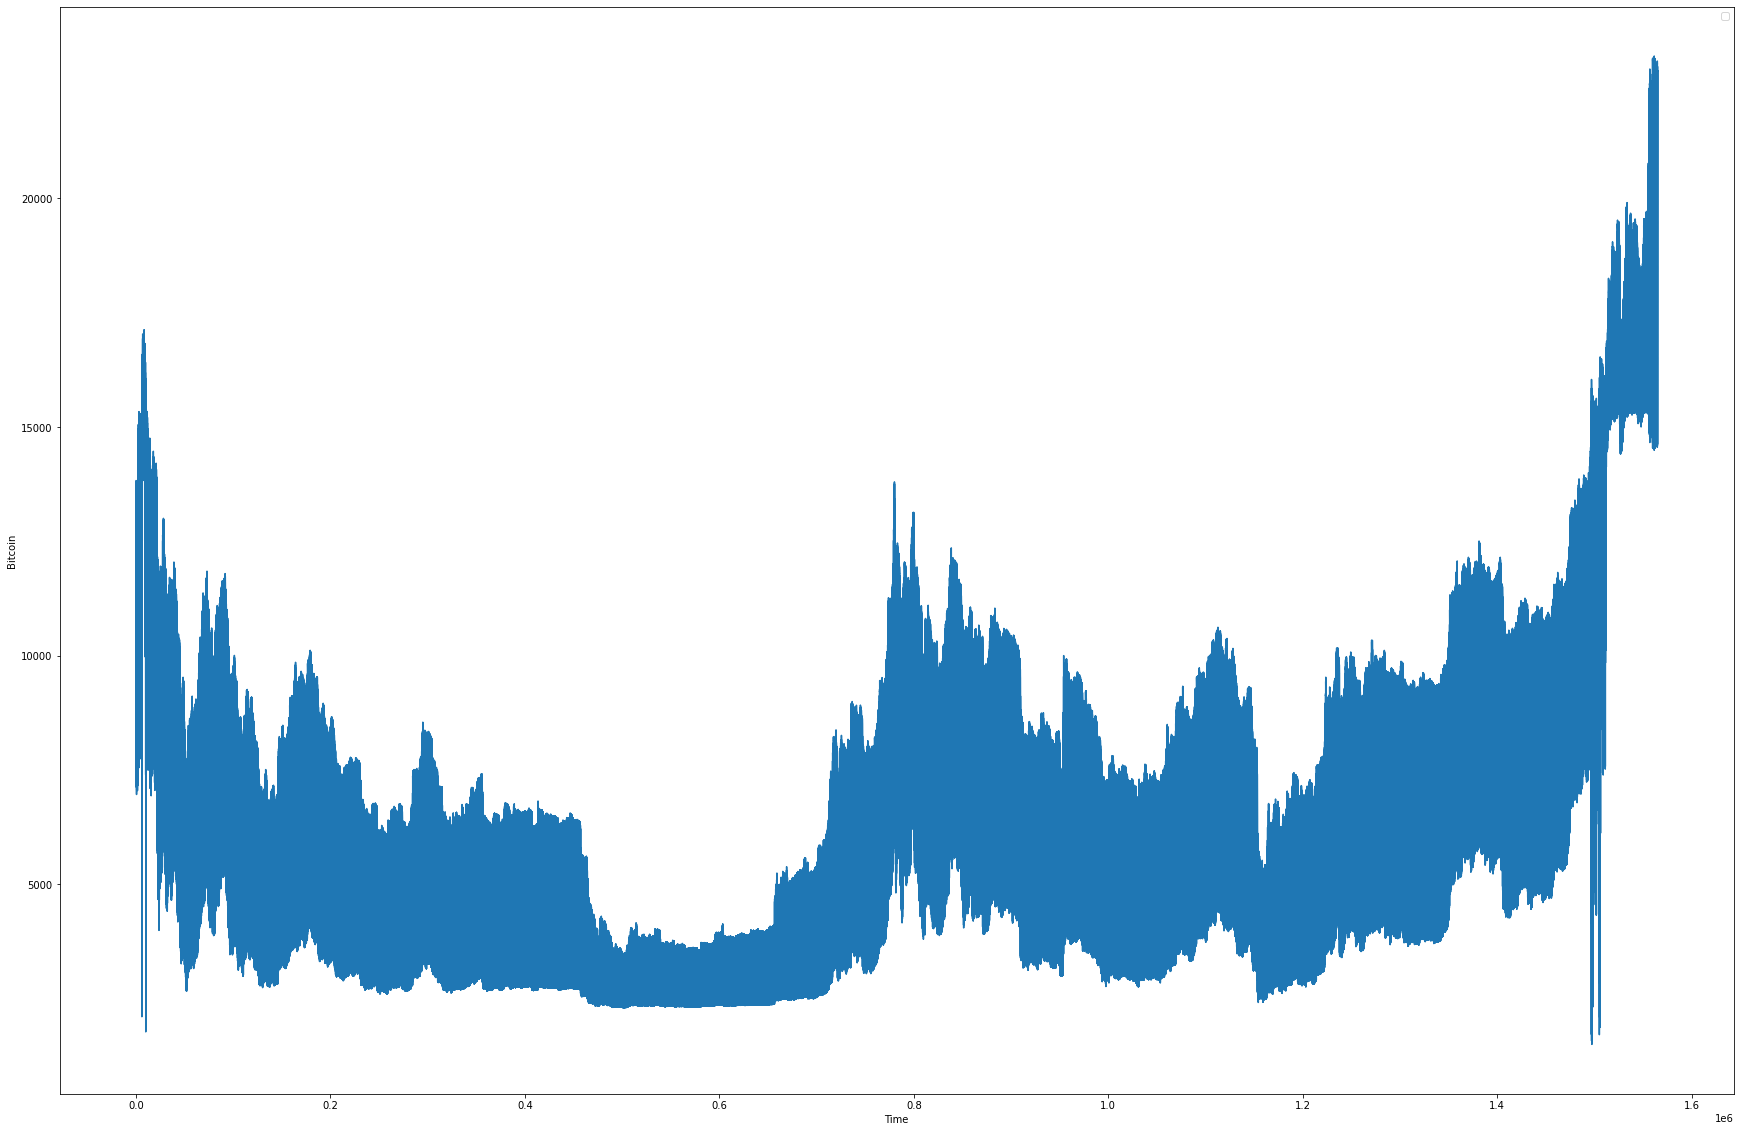

In [39]:
import matplotlib.pyplot as plt

# plot vwap time series for both chosen assets
f = plt.figure(figsize=(30,20))

plt.plot(predictions.flatten())
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')


plt.show()


In [24]:
batched_labels[0]

[13521.08611745667,
 13480.027747274367,
 13480.274374858667,
 13475.417970065491,
 13473.816245981414,
 13444.276492232975,
 13436.799332982822,
 13409.28915944893,
 13424.992189285113,
 13445.30429264183,
 13452.181361153542,
 13438.18418700408,
 13426.543370343024,
 13421.741408910097,
 13397.35011947857,
 13355.646185616068,
 13329.10999444231,
 13330.23048546794,
 13349.523234417473,
 13352.45884140913,
 13374.9806945501,
 13390.644589816477,
 13409.732818849152,
 13426.995810890488,
 13468.16731674126,
 13440.22087616522,
 13399.58891896482,
 13394.151518275194,
 13406.405798167783,
 13434.436351531323,
 13444.366216040618,
 13450.07830430446,
 13454.00556794963,
 13469.991614972703,
 13442.176811908075,
 13438.327377905156,
 13429.717739615557,
 13400.88798706276,
 13366.585935945288,
 13357.680593125991,
 13361.679027687398,
 13376.795323953347,
 13411.702382125386,
 13408.721628915688,
 13411.828802791091,
 13378.992187254817,
 13374.20024810254,
 13403.671844378328,
 13364.86

In [25]:
np.array(predictions[0])

array([[ 7476.6   ],
       [13221.26  ],
       [13692.272 ],
       [13633.306 ],
       [13599.066 ],
       [13588.797 ],
       [13588.789 ],
       [13589.552 ],
       [13589.544 ],
       [13589.426 ],
       [13589.609 ],
       [13587.865 ],
       [13586.98  ],
       [13584.217 ],
       [13581.648 ],
       [13578.938 ],
       [13575.432 ],
       [13570.722 ],
       [13565.805 ],
       [13561.784 ],
       [13557.881 ],
       [13553.3   ],
       [13550.59  ],
       [13547.9375],
       [13545.2705],
       [13543.925 ],
       [13542.177 ],
       [13539.044 ],
       [13536.009 ],
       [13533.783 ],
       [13532.208 ],
       [13529.206 ],
       [13526.513 ],
       [13525.117 ],
       [13523.383 ],
       [13521.489 ],
       [13520.015 ],
       [13517.941 ],
       [13515.569 ],
       [13513.68  ],
       [13510.231 ],
       [13507.155 ],
       [13504.609 ],
       [13501.952 ],
       [13500.143 ],
       [13497.681 ],
       [13493.884 ],
       [13490

In [41]:
!mkdir -p saved_model
model.save('/content/drive/MyDrive/Colab Notebooks/CryptoPricePredictionApp')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CryptoPricePredictionApp/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CryptoPricePredictionApp/assets
